<a href="https://colab.research.google.com/github/Cloblak/aipi540_deeplearning/blob/main/1D_CNN_Attempts/1D_CNN_WorkingPipeLine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install alpaca_trade_api

Features To Consider
 - Targets are only predicting sell within market hours, i.e. at 1530, target is prediciting price for 1100 the next day.  Data from pre and post market is taken into consideration, and a sell or buy will be indicated if the price will flucuate after close.

In [2]:
# Import Dependencies
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm
import alpaca_trade_api as tradeapi
from datetime import datetime, timedelta, tzinfo, timezone, time
import os.path
import ast
import threading
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
random_seed = 101
torch.manual_seed(random_seed)

In [4]:
PAPER_API_KEY = "PKE39LILN9SL1FMJMFV7"
PAPER_SECRET_KEY = "TkU7fXH6WhP15MewgWlSnQG5RUoHGOPQ7yqlD6xq"
PAPER_BASE_URL = 'https://paper-api.alpaca.markets'

In [5]:
api = tradeapi.REST(PAPER_API_KEY, PAPER_SECRET_KEY, PAPER_BASE_URL, api_version='v2')

In [6]:
def prepost_train_test_validate_offset_data(api, ticker, interval, train_days=180, test_days=60, validate_days=30, offset_days = 0):
    ticker_data_dict = None
    ticker_data_dict = {}
    monthly_data_dict = None
    monthly_data_dict = {}
    interval_loop_data = None
    interval_loop_data = pd.DataFrame()
    stock_data = None
    
    days_to_collect = train_days + test_days + validate_days + offset_days

    TZ = 'US/Eastern'

    start = pd.to_datetime((datetime.now() - timedelta(days=days_to_collect)).strftime("%Y-%m-%d %H:%M"), utc=True)
    end = pd.to_datetime(datetime.now().strftime("%Y-%m-%d %H:%M"), utc=True)

    stock_data = api.get_bars(ticker, interval, start = start.isoformat(), end=end.isoformat(), adjustment="raw").df
    
    interval_loop_data = interval_loop_data.append(stock_data)
    df_start_ref = interval_loop_data.index[0]
    start_str_ref = pd.to_datetime(start, utc=True)

    while start_str_ref.value < ( pd.to_datetime(df_start_ref, utc=True) - pd.Timedelta(days=2.5)).value:
        end_new = pd.to_datetime(interval_loop_data.index[0].strftime("%Y-%m-%d %H:%M"), utc=True).isoformat()
        stock_data_new = None
        stock_data_new = api.get_bars(ticker, interval, start=start, end=end_new, adjustment="raw").df
        #stock_data_new = stock_data_new.reset_index()
        interval_loop_data = interval_loop_data.append(stock_data_new).sort_values(by=['index'], ascending=True)
        df_start_ref = interval_loop_data.index[0]
        
    stock_yr_min_df = interval_loop_data.copy()
    stock_yr_min_df["Open"] = stock_yr_min_df['open']
    stock_yr_min_df["High"]= stock_yr_min_df["high"]
    stock_yr_min_df["Low"] = stock_yr_min_df["low"]
    stock_yr_min_df["Close"] = stock_yr_min_df["close"]
    stock_yr_min_df["Volume"] = stock_yr_min_df["volume"]
    stock_yr_min_df["VolumeWeightedAvgPrice"] = stock_yr_min_df["vwap"]
    stock_yr_min_df["Time"] = stock_yr_min_df.index.tz_convert(TZ)
    stock_yr_min_df.index = stock_yr_min_df.index.tz_convert(TZ)
    final_df = stock_yr_min_df.filter(["Time", "Open", "High", "Low", "Close", "Volume", "VolumeWeightedAvgPrice"], axis = 1)
    
    first_day = final_df.index[0]
    traintest_day = final_df.index[-1] - pd.Timedelta(days= test_days+validate_days+offset_days)
    valtest_day = final_df.index[-1] - pd.Timedelta(days= test_days+offset_days)
    last_day = final_df.index[-1] - pd.Timedelta(days= offset_days)
    training_df =  final_df.loc[first_day:traintest_day] #(data_split - pd.Timedelta(days=1))]
    validate_df = final_df.loc[traintest_day:valtest_day]
    testing_df =  final_df.loc[valtest_day:last_day]
    full_train = final_df.loc[first_day:last_day]
    offset_df =  final_df.loc[last_day:]

    return training_df, validate_df, testing_df, full_train, offset_df, final_df, traintest_day, valtest_day

def markethours_train_test_validate_offset_data(api, ticker, interval, train_days=180, test_days=60, validate_days=30, offset_days = 0):
    ticker_data_dict = None
    ticker_data_dict = {}
    monthly_data_dict = None
    monthly_data_dict = {}
    interval_loop_data = None
    interval_loop_data = pd.DataFrame()
    stock_data = None
    
    days_to_collect = train_days + test_days + validate_days + offset_days

    TZ = 'US/Eastern'

    start = pd.to_datetime((datetime.now() - timedelta(days=days_to_collect)).strftime("%Y-%m-%d %H:%M"), utc=True)
    end = pd.to_datetime(datetime.now().strftime("%Y-%m-%d %H:%M"), utc=True)

    stock_data = api.get_barset(ticker, interval, start = start.isoformat(), end=end.isoformat()).df
    
    interval_loop_data = interval_loop_data.append(stock_data)
    df_start_ref = interval_loop_data.index[0]
    start_str_ref = pd.to_datetime(start, utc=True)

    while start_str_ref.value < ( pd.to_datetime(df_start_ref, utc=True) - pd.Timedelta(days=2.5)).value:
        end_new = pd.to_datetime(interval_loop_data.index[0].strftime("%Y-%m-%d %H:%M"), utc=True).isoformat()
        stock_data_new = None
        stock_data_new = api.get_barset(ticker, interval, start=start, end=end_new).df
        interval_loop_data = interval_loop_data.append(stock_data_new).sort_values(by=['time'], ascending=True)
        df_start_ref = interval_loop_data.index[0]
        
    stock_yr_min_df = interval_loop_data.copy()
    pre_final = pd.DataFrame()
    pre_final["Open"] = stock_yr_min_df[ticker]['open']
    pre_final["High"]= stock_yr_min_df[ticker]["high"]
    pre_final["Low"] = stock_yr_min_df[ticker]["low"]
    pre_final["Close"] = stock_yr_min_df[ticker]["close"]
    pre_final["Volume"] = stock_yr_min_df[ticker]["volume"]
    pre_final["Time"] = stock_yr_min_df.index.tz_convert(TZ)
    pre_final.index = stock_yr_min_df.index.tz_convert(TZ)
    
    final_df = pre_final.filter(["Time", "Open", "High", "Low", "Close", "Volume"], axis = 1).between_time('9:29', '16:05')
    
    first_day = final_df.index[0]
    traintest_day = final_df.index[-1] - pd.Timedelta(days= test_days+validate_days+offset_days)
    valtest_day = final_df.index[-1] - pd.Timedelta(days= test_days+offset_days)
    last_day = final_df.index[-1] - pd.Timedelta(days= offset_days)
    training_df =  final_df.loc[first_day:traintest_day] #(data_split - pd.Timedelta(days=1))]
    validate_df = final_df.loc[traintest_day:valtest_day]
    testing_df =  final_df.loc[valtest_day:last_day]
    full_train = final_df.loc[first_day:last_day]
    offset_df =  final_df.loc[last_day:]


    return training_df, validate_df, testing_df, full_train, offset_df, final_df, traintest_day, valtest_day




In [7]:
from datetime import date

train_start = date(2017, 1, 1)
train_end = date(2019, 10, 31)
train_delta = train_end - train_start
print(f'Number of days of Training Data {train_delta.days}')

val_day_num = 400
print(f'Number of days of Validation Data {val_day_num}')

test_start = train_end + timedelta(val_day_num)
test_end = date.today()
test_delta = (test_end - test_start)
print(f'Number of days of Holdout Test Data {test_delta.days}')

ticker = "WMT" # Ticker Symbol to Test
interval = "5Min" # Interval of bars
train_day_int = train_delta.days # Size of training set (Jan 2010 - Oct 2017)
val_day_int = val_day_num # Size of validation set
test_day_int = test_delta.days # Size of test set
offset_day_int = 0 # Number of days to off set the training data
train, val, test, full, offset, complete, traintest_day, testval_day = prepost_train_test_validate_offset_data(api, ticker, 
                                                                                     interval, 
                                                                                     train_days=train_day_int, 
                                                                                     test_days=test_day_int, 
                                                                                     validate_days=val_day_int,
                                                                                     offset_days = offset_day_int)

Number of days of Training Data 1033
Number of days of Validation Data 400
Number of days of Holdout Test Data 421


In [8]:
def timeFilterAndBackfill(df):
  """ 
  Prep df to be filled out for each trading day:
  Time Frame: 0730-1730
  Backfilling NaNs
  Adjusting Volume to Zero if no Trading data is present
     - Assumption is that there were no trades duing that time  
  """
  
  df = df.between_time('07:29','17:26')

  TZ = 'US/Eastern'

  start_dateTime = pd.Timestamp(year = df.index[0].year, 
                                month = df.index[0].month, 
                                day = df.index[0].day, 
                                hour = 7, minute = 25, tz = TZ)

  end_dateTime = pd.Timestamp(year = df.index[-1].year, 
                              month = df.index[-1].month, 
                              day = df.index[-1].day, 
                              hour = 17, minute = 35, tz = TZ)

  dateTime_index = pd.date_range(start_dateTime,
                                end_dateTime, 
                                freq='5min').tolist()

  dateTime_index_df = pd.DataFrame()
  dateTime_index_df["Time"] = dateTime_index 
  filtered_df = pd.merge_asof(dateTime_index_df, df,  
                              on='Time', 
                              direction='backward').set_index("Time").between_time('07:29','17:26')

  volumeset_list = []
  prev_v = None

  for v in filtered_df["Volume"]:
    
    if prev_v == None:
      if math.isnan(v):
        prev_v = 0
        volumeset_list.append(0)
      else:
        prev_v = v
        volumeset_list.append(v)

    elif prev_v != None:
      if v == prev_v:
        volumeset_list.append(0)
        prev_v = v
      elif math.isnan(v):
        volumeset_list.append(0)
        prev_v = 0
      else:
        volumeset_list.append(v)
        prev_v = v


  filtered_df["Volume"] = volumeset_list
  adjvolumeset_list = []

  prev_v = None

  for v in filtered_df["VolumeWeightedAvgPrice"]:
    if prev_v == None:
      if math.isnan(v):
        prev_v = 0
        adjvolumeset_list.append(0)
      else:
        prev_v = v
        adjvolumeset_list.append(v)
    elif prev_v != None:
      if v == prev_v:
        adjvolumeset_list.append(0)
        prev_v = v
      elif math.isnan(v):
        adjvolumeset_list.append(0)
        prev_v = 0
      else:
        adjvolumeset_list.append(v)
        prev_v = v

  filtered_df["VolumeWeightedAvgPrice"] = adjvolumeset_list

  preped_df = filtered_df.backfill()

  return preped_df

def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    assert h % nrows == 0, f"{h} rows is not evenly divisible by {nrows}"
    assert w % ncols == 0, f"{w} cols is not evenly divisible by {ncols}"
    return np.flip(np.rot90((arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols)), axes = (1, 2)), axis = 1)
  

def buildOutData_TorchPrep(train_df = train, val_df = val, test_df = test):
  pass

In [9]:
train = timeFilterAndBackfill(train)
val = timeFilterAndBackfill(val)
test = timeFilterAndBackfill(test)

In [10]:
train

,Open,High,Low,Close,Volume,VolumeWeightedAvgPrice
Time,,,,,,
2017-01-03 07:30:00-05:00,69.15,69.15,69.15,69.15,0.0,0.0
2017-01-03 07:35:00-05:00,69.15,69.15,69.15,69.15,0.0,0.0
2017-01-03 07:40:00-05:00,69.15,69.15,69.15,69.15,0.0,0.0
2017-01-03 07:45:00-05:00,69.15,69.15,69.15,69.15,0.0,0.0
2017-01-03 07:50:00-05:00,69.15,69.15,69.15,69.15,0.0,0.0
...,...,...,...,...,...,...
2019-10-30 17:05:00-04:00,118.10,118.11,118.10,118.10,0.0,0.0
2019-10-30 17:10:00-04:00,118.10,118.11,118.10,118.10,0.0,0.0
2019-10-30 17:15:00-04:00,118.10,118.11,118.10,118.10,0.0,0.0


In [11]:
train_tonp = train[["Open", "High", "Low", "Close", "Volume"]]
val_tonp = val[["Open", "High", "Low", "Close", "Volume"]]
test_tonp = test[["Open", "High", "Low", "Close", "Volume"]]
train_array = train_tonp.to_numpy()
val_array = val_tonp.to_numpy()
test_array = test_tonp.to_numpy()
X_train = blockshaped(train_array, 24, 5)
X_val = blockshaped(val_array, 24, 5)
X_test = blockshaped(test_array, 24, 5)

In [12]:
test[24:48]

,Open,High,Low,Close,Volume,VolumeWeightedAvgPrice
Time,,,,,,
2020-12-04 09:30:00-05:00,149.5100,149.5100,148.7100,148.8600,231923.0,149.180813
2020-12-04 09:35:00-05:00,148.8600,149.0000,148.1751,148.4200,149407.0,148.595039
2020-12-04 09:40:00-05:00,148.3775,148.8900,148.3000,148.3200,111228.0,148.548161
2020-12-04 09:45:00-05:00,148.4100,148.7000,148.2370,148.6750,77056.0,148.457488
2020-12-04 09:50:00-05:00,148.6686,148.9100,148.6100,148.7300,99921.0,148.786323
2020-12-04 09:55:00-05:00,148.7000,148.7000,148.5200,148.6450,75181.0,148.592995
2020-12-04 10:00:00-05:00,148.6700,148.6750,148.2800,148.4800,100701.0,148.416309
2020-12-04 10:05:00-05:00,148.4800,148.6300,148.2600,148.3294,88675.0,148.401629
2020-12-04 10:10:00-05:00,148.3000,148.3181,148.1000,148.1801,128189.0,148.188385


In [13]:
np.set_printoptions(linewidth=1000)
X_train[0]

array([[  69.15,   69.15,   69.15,   69.15,   69.15,   69.15,   69.15,   69.15,   69.15,   69.15,   69.12,   69.3 ,   69.3 ,   69.3 ,   69.3 ,   69.3 ,   69.35,   69.35,   69.35,   69.35,   69.35,   69.35,   69.3 ,   69.22],
       [  69.15,   69.15,   69.15,   69.15,   69.15,   69.15,   69.15,   69.15,   69.15,   69.15,   69.12,   69.3 ,   69.3 ,   69.3 ,   69.3 ,   69.3 ,   69.35,   69.35,   69.35,   69.35,   69.35,   69.35,   69.3 ,   69.24],
       [  69.15,   69.15,   69.15,   69.15,   69.15,   69.15,   69.15,   69.15,   69.15,   69.15,   69.12,   69.3 ,   69.3 ,   69.3 ,   69.3 ,   69.3 ,   69.35,   69.35,   69.35,   69.35,   69.35,   69.35,   69.2 ,   68.9 ],
       [  69.15,   69.15,   69.15,   69.15,   69.15,   69.15,   69.15,   69.15,   69.15,   69.15,   69.12,   69.3 ,   69.3 ,   69.3 ,   69.3 ,   69.3 ,   69.35,   69.35,   69.35,   69.35,   69.35,   69.35,   69.23,   69.01],
       [   0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,  111.  ,    0.  ,    0.  ,    0.  , 17

In [14]:
X_train[0][3][-1]

69.01

In [16]:
# create target from OHLC and Volume Data
def buildTargets(obs_array,  
                 alph = .55, 
                 volity_int = 8):

  """ 
  This function will take a complete set of train, val, and test 
  data and return the targets. Volitility will be calculated over 
  the 24 5min incriments. The Target shift is looking at 2 hours 
  shift from current time

  shift_2hour = The amount of time the data interval take to equal 2 hours 
                (i.e. 5 min data interval is equal to 24)
  alph = The alpha value for calculating the shift in price
  volity_int = the number of incriments used to calculate volitility 
  """

  target_close_list =[]

  for arr in obs_array:
    target_close_list.append(arr[3][-1])
  
  target_close_df = pd.DataFrame()
  target_close_df["Close"] = target_close_list

  returns = np.log(target_close_df['Close']/(target_close_df['Close'].shift(1)))
  returns.fillna(0, inplace=True)
  volatility = returns.rolling(window=volity_int).std()*np.sqrt(volity_int)
  
  targets = [2] * len(target_close_df.Close)

  targets = np.where(target_close_df.Close.shift(-1) >= (target_close_df.Close * (1 + alph * volatility)), 
           1, targets)
  
  targets = np.where(target_close_df.Close.shift(-1) <= (target_close_df.Close * (1 - alph * volatility)), 
           0, targets)

  return targets

In [17]:
volity_val = 2
y_train = buildTargets(X_train, volity_int = volity_val)
y_val = buildTargets(X_val, volity_int = volity_val)
y_test = buildTargets(X_test, volity_int = volity_val)

In [18]:
X_train = X_train.reshape(X_train.shape[0], 1,
                          X_train.shape[1], 
                          X_train.shape[2])
X_val = X_val.reshape(X_val.shape[0], 1,
                          X_val.shape[1], 
                          X_val.shape[2])
X_test = X_test.reshape(X_test.shape[0], 1,
                          X_test.shape[1], 
                          X_test.shape[2])

In [19]:
print(f'X Train Length {X_train.shape}, y Train Label Length {y_train.shape}')
print(f'X Val Length {X_val.shape}, y Val Label Length {y_val.shape}')
print(f'X Test Length {X_test.shape}, y Test Label Length {y_test.shape}')

X Train Length (5155, 1, 5, 24), y Train Label Length (5155,)
X Val Length (2000, 1, 5, 24), y Val Label Length (2000,)
X Test Length (2105, 1, 5, 24), y Test Label Length (2105,)


In [20]:
X_train[0]

array([[[  69.15,   69.15,   69.15,   69.15,   69.15,   69.15,   69.15,   69.15,   69.15,   69.15,   69.12,   69.3 ,   69.3 ,   69.3 ,   69.3 ,   69.3 ,   69.35,   69.35,   69.35,   69.35,   69.35,   69.35,   69.3 ,   69.22],
        [  69.15,   69.15,   69.15,   69.15,   69.15,   69.15,   69.15,   69.15,   69.15,   69.15,   69.12,   69.3 ,   69.3 ,   69.3 ,   69.3 ,   69.3 ,   69.35,   69.35,   69.35,   69.35,   69.35,   69.35,   69.3 ,   69.24],
        [  69.15,   69.15,   69.15,   69.15,   69.15,   69.15,   69.15,   69.15,   69.15,   69.15,   69.12,   69.3 ,   69.3 ,   69.3 ,   69.3 ,   69.3 ,   69.35,   69.35,   69.35,   69.35,   69.35,   69.35,   69.2 ,   68.9 ],
        [  69.15,   69.15,   69.15,   69.15,   69.15,   69.15,   69.15,   69.15,   69.15,   69.15,   69.12,   69.3 ,   69.3 ,   69.3 ,   69.3 ,   69.3 ,   69.35,   69.35,   69.35,   69.35,   69.35,   69.35,   69.23,   69.01],
        [   0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,  111.  ,    0.  ,    0.  ,    0. 

In [21]:
def get_class_distribution(obj):
    count_dict = {
        "up": 0,
        "flat": 0,
        "down": 0,
    }
    
    for i in obj:
        if i == 1: 
            count_dict['up'] += 1
        elif i == 0: 
            count_dict['down'] += 1
        elif i == 2: 
            count_dict['flat'] += 1             
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

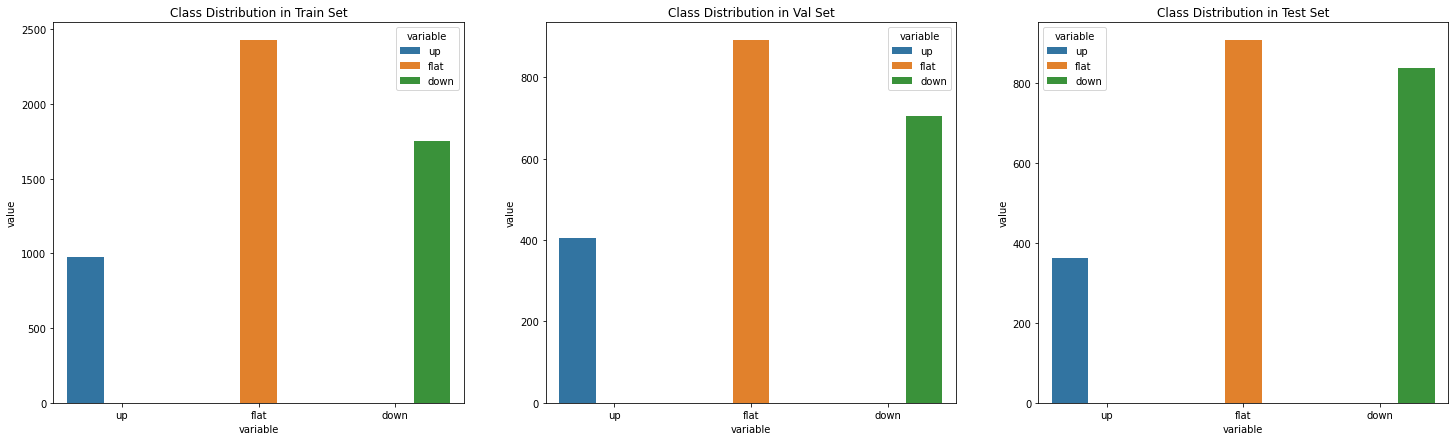

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [23]:
######
# Code fro scaling at a later date
######

# from sklearn.preprocessing import MinMaxScaler

# scalers = {}
# for i in range(X_train.shape[1]):
#     scalers[i] = MinMaxScaler()
#     X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) 

# for i in range(X_val.shape[1]):
#     X_test[:, i, :] = scalers[i].transform(X_test[:, i, :]) 

# for i in range(X_test.shape[1]):
#     X_test[:, i, :] = scalers[i].transform(X_test[:, i, :]) 

In [24]:
print(f'X Train Length {X_train.shape}, y Train Label Length {y_train.shape}')
print(f'X Val Length {X_val.shape}, y Val Label Length {y_val.shape}')
print(f'X Test Length {X_test.shape}, y Test Label Length {y_test.shape}')
print("")
print('Training data window: ', len(X_train))
print('Val data windows: ', len(X_val))

X Train Length (5155, 1, 5, 24), y Train Label Length (5155,)
X Val Length (2000, 1, 5, 24), y Val Label Length (2000,)
X Test Length (2105, 1, 5, 24), y Test Label Length (2105,)

Training data window:  5155
Val data windows:  2000


In [25]:
y_train[0].dtype

dtype('int64')

In [26]:
batch_size = 5

train_data = []
for i in range(len(X_train)):
   train_data.append([X_train[i].astype('float'), y_train[i]])

train_loader = torch.utils.data.DataLoader(train_data, shuffle=False, batch_size=batch_size)
i1, l1 = next(iter(train_loader))
print(i1.shape)

val_data = []
for i in range(len(X_val)):
   val_data.append([X_val[i].astype('float'), y_val[i]])

val_loader = torch.utils.data.DataLoader(val_data, shuffle=False, batch_size=batch_size)
i1, l1 = next(iter(val_loader))
print(i1.shape)

torch.Size([5, 1, 5, 24])
torch.Size([5, 1, 5, 24])


In [27]:
# Get next batch of training images
windows, labels = iter(train_loader).next()
print(windows.shape)
windows = windows.numpy()

# plot the windows in the batch, along with the corresponding labels
fig = plt.figure(figsize=(15, 5))
for idx in range(batch_size):
    print(labels[idx])

torch.Size([5, 1, 5, 24])
tensor(2)
tensor(2)
tensor(2)
tensor(1)
tensor(0)


<Figure size 1080x360 with 0 Axes>

In [28]:
class StockShiftClassification(nn.Module):
  def __init__(self):
    super(StockShiftClassification, self).__init__()

    self.conv1 = nn.Conv2d(1, 32, kernel_size = (1,3), stride=1, padding = 1)
    self.pool1 = nn.MaxPool2d(4,4)

    self.conv2 = nn.Conv2d(32, 64, kernel_size = (1,3), stride=1, padding = 1)
    self.pool2 = nn.MaxPool2d(3,3)  

    self.conv3 = nn.Conv2d(64, 128, kernel_size = (1,3), stride=1, padding = 1)
    self.pool3 = nn.MaxPool2d(2,2)

    self.fc1 = nn.Linear(128,1000)
    self.fc2 = nn.Linear(1000,500)


  def forward(self, x):

    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = F.relu(self.conv2(x))
    x = self.pool2(x)
    x = F.relu(self.conv3(x))
    x = self.pool3(x)

    x = x.view(x.size(0), -1)

    # Linear layer
    x = self.fc1(x)
    x = self.fc2(x)

    output = F.log_softmax(x, dim=1)

    return output


In [29]:
# Instantiate the model
net = StockShiftClassification().float()

# Display a summary of the layers of the model and output shape after each layer
summary(net,(windows.shape[1:]),batch_size=batch_size,device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [5, 32, 7, 24]             128
         MaxPool2d-2              [5, 32, 1, 6]               0
            Conv2d-3              [5, 64, 3, 6]           6,208
         MaxPool2d-4              [5, 64, 1, 2]               0
            Conv2d-5             [5, 128, 3, 2]          24,704
         MaxPool2d-6             [5, 128, 1, 1]               0
            Linear-7                  [5, 1000]         129,000
            Linear-8                   [5, 500]         500,500
Total params: 660,540
Trainable params: 660,540
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.35
Params size (MB): 2.52
Estimated Total Size (MB): 2.87
----------------------------------------------------------------


In [30]:
# Cross entropy loss combines softmax and nn.NLLLoss() in one single class.
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

In [31]:
def train_model(model,criterion,optimizer,train_loader,n_epochs,device):
    
    loss_over_time = [] # to track the loss as the network trains
    
    model = model.to(device).double() # Send model to GPU if available
    model.train() # Set the model to training mode
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        
        for i, data in enumerate(train_loader):
            
            # Get the input images and labels, and send to GPU if available
            inputs, labels = data[0].to(device), data[1].to(device)

            # Zero the weight gradients
            optimizer.zero_grad()

            # Forward pass to get outputs
            outputs = model(inputs)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Backpropagation to get the gradients with respect to each weight
            loss.backward()

            # Update the weights
            optimizer.step()

            # Convert loss into a scalar and add it to running_loss
            running_loss += loss.item()
            
            if i % 1000 == 999:    # print every 1000 batches
                avg_loss = running_loss/1000
                # record and print the avg loss over the 1000 batches
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}, Avg. Loss: {:.4f}'.format(epoch + 1, i+1, avg_loss))
                running_loss = 0.0

    return loss_over_time

Epoch: 1, Batch: 1000, Avg. Loss: 1.0334
Epoch: 2, Batch: 1000, Avg. Loss: 1.0312
Epoch: 3, Batch: 1000, Avg. Loss: 1.0294
Epoch: 4, Batch: 1000, Avg. Loss: 1.0279
Epoch: 5, Batch: 1000, Avg. Loss: 1.0267
Epoch: 6, Batch: 1000, Avg. Loss: 1.0255
Epoch: 7, Batch: 1000, Avg. Loss: 1.0246
Epoch: 8, Batch: 1000, Avg. Loss: 1.0238
Epoch: 9, Batch: 1000, Avg. Loss: 1.0231
Epoch: 10, Batch: 1000, Avg. Loss: 1.0224
Epoch: 11, Batch: 1000, Avg. Loss: 1.0218
Epoch: 12, Batch: 1000, Avg. Loss: 1.0212
Epoch: 13, Batch: 1000, Avg. Loss: 1.0208
Epoch: 14, Batch: 1000, Avg. Loss: 1.0203
Epoch: 15, Batch: 1000, Avg. Loss: 1.0198
Epoch: 16, Batch: 1000, Avg. Loss: 1.0196
Epoch: 17, Batch: 1000, Avg. Loss: 1.0191
Epoch: 18, Batch: 1000, Avg. Loss: 1.0188
Epoch: 19, Batch: 1000, Avg. Loss: 1.0184
Epoch: 20, Batch: 1000, Avg. Loss: 1.0181
Epoch: 21, Batch: 1000, Avg. Loss: 1.0178
Epoch: 22, Batch: 1000, Avg. Loss: 1.0175
Epoch: 23, Batch: 1000, Avg. Loss: 1.0174
Epoch: 24, Batch: 1000, Avg. Loss: 1.0171
E

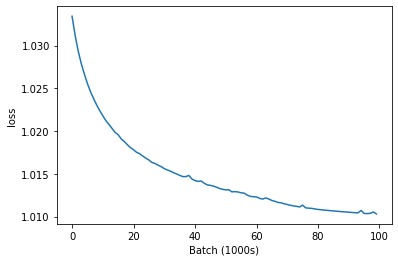

In [43]:
# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_epochs = 100
cost_path = train_model(net.float(),criterion,optimizer,train_loader,n_epochs,device)

# visualize the loss as the network trained
plt.plot(cost_path)
plt.xlabel('Batch (1000s)')
plt.ylabel('loss')
plt.show()

In [44]:
def test_model(model,test_loader,device):
    # Turn autograd off
    with torch.no_grad():

        # Set the model to evaluation mode
        model = model.to(device)
        model.eval()

        # Set up lists to store true and predicted values
        y_true = []
        test_preds = []

        # Calculate the predictions on the test set and add to list
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            # Feed inputs through model to get raw scores
            logits = model.forward(inputs)
            # Convert raw scores to probabilities (not necessary since we just care about discrete probs in this case)
            probs = F.softmax(logits,dim=1)
            # Get discrete predictions using argmax
            preds = np.argmax(probs.cpu().numpy(),axis=1)
            # Add predictions and actuals to lists
            test_preds.extend(preds)
            y_true.extend(labels)

        # Calculate the accuracy
        test_preds = np.array(test_preds)
        y_true = np.array(y_true)
        test_acc = np.sum(test_preds == y_true)/y_true.shape[0]
        
        # Recall for each class
        recall_vals = []
        for i in range(3):
            class_idx = np.argwhere(y_true==i)
            total = len(class_idx)
            correct = np.sum(test_preds[class_idx]==i)
            recall = correct / total
            recall_vals.append(recall)
    
    return test_acc,recall_vals

In [45]:
classes = [0,1,2]

In [46]:
# Calculate the test set accuracy and recall for each class
acc,recall_vals = test_model(net,val_loader,device)
print('Test set accuracy is {:.3f}'.format(acc))
for i in range(3):
    print('For class {}, recall is {}'.format(classes[i],recall_vals[i]))

Test set accuracy is 0.352
For class 0, recall is 1.0
For class 1, recall is 0.0
For class 2, recall is 0.0


# Working Code

In [480]:
import torch.nn as nn
import torch.nn.functional as F

class StockClassificationBase(nn.Module):
    
    def training_step(self, batch):
        windows, labels = batch 
        out = self(windows)                 # Generate predictions
        loss = F.cross_entropy(out, labels.long()) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        windows, labels = batch 
        out = self(windows)                   # Generate predictions
        loss = F.cross_entropy(out, labels.long())   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        if len(batch_losses) == 0:
          epoch_loss = torch.stack(torch.FloatTensor((0))).mean()
        else:
          epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        if len(batch_accs) == 0:
          epoch_acc = torch.stack(torch.FloatTensor((0))).mean()
        else:
          epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [481]:
class StockShiftClassification(StockClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(1, 32, kernel_size = (1,3), stride=1, padding = 0).double(),
            nn.MaxPool2d(4,4),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = (1,3), stride = 1, padding = 1).double(),
            nn.ReLU(),
            nn.MaxPool2d(3,3),
            nn.Conv2d(64, 128, kernel_size = (1,3), stride = 1, padding = 1).double(),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(128,500).double(),
            nn.ReLU(),
            nn.Linear(500, 3).double()

        )
    
    def forward(self, xb):
        return self.network(xb)

In [482]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [483]:
# Instantiate the model
model = StockShiftClassification()

In [484]:
num_epochs = 30
opt_func = torch.optim.Adam
lr = 0.001
#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_loader, val_loader, opt_func)

TypeError: ignored

In [247]:
class ConvNet(nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()
        #Input shape: (batch_size,1,5,24)
        
        # Convolutional 1 layer: 1x3 kernel, stride=1, padding=0, 32 output channels / feature maps
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=(1,3), stride=1, padding=1)
        # Conv1 layer output size = (W-F+2P)/S+1 = (5-(3))/1+1 = 1
        # Conv1 layer output shape for one image: [1,5,24]
        
        # Maxpool layer: kernel_size=4, stride=4
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=4)
        # Pool output shape for one image: [10,13,13]
        
        # Convolutional 2 layer: 3x3 kernel, stride=1, padding=0, 20 output channels / feature maps
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(1,3), stride=1, padding=0)
        # Conv2 layer output size = (W-F+2P)/S+1 = (13-3)/1+1 = 11
        # Conv2 layer output shape for one image: [20,11,11]
        
        # Maxpool layer: kernel_size=2, stride=2
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=3)
        # Pool output shape for one image: [20,5,5]

        # Convolutional 2 layer: 3x3 kernel, stride=1, padding=0, 20 output channels / feature maps
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(1,3), stride=1, padding=0)
        # Conv2 layer output size = (W-F+2P)/S+1 = (13-3)/1+1 = 11
        # Conv2 layer output shape for one image: [20,11,11]
        
        # Maxpool layer: kernel_size=2, stride=2
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Pool output shape for one image: [20,5,5]
        
        # Input size: 20 * 5 * 5 = 500 from pool2 pooling layer
        # 10 output channels (for the 10 classes)
        self.fc1 = nn.Linear(1000, 3)

        self.fc2 = nn.Linear(500, 3)
        
    def forward(self, x):
        # Two convolutional layers followed by relu and then pooling
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        # Flatten into a vector to feed into linear layer
        x = x.view(x.size(0), -1)
        
        # Linear layer
        x = self.fc1(x)
        x = self.fc2(x)

        return x

In [248]:
# Instantiate the model
net = ConvNet()

# Display a summary of the layers of the model and output shape after each layer
summary(net,(windows.shape[1:]),batch_size=batch_size,device="cpu")

RuntimeError: ignored

In [195]:

class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 32, kernel_size=(1,3), stride=1, padding=1),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=1, stride=4),
            # Defining another 2D convolution layer
            Conv2d(32, 64, kernel_size=(1,3), stride=1, padding=1),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=1, stride=3),
        )

        self.linear_layers = Sequential(
            Linear(4 * 7 * 7, 10)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [196]:
# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(1, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=1, stride=4, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(1, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=1, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=196, out_features=10, bias=True)
  )
)


In [197]:
def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_val)

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)

In [200]:
# defining the number of epochs
n_epochs = 25
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    train(epoch)

RuntimeError: ignored

In [108]:
class ClassifierDataset():
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [111]:
EPOCHS = 300
BATCH_SIZE = 1
LEARNING_RATE = 0.0007
NUM_FEATURES = 24
NUM_CLASSES = 3

In [113]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [138]:
# class MulticlassClassification(nn.Module):
#     def __init__(self, num_feature, num_class):
#         super(MulticlassClassification, self).__init__()
        
#         self.layer_1 = nn.Linear(num_feature, 32)
#         self.layer_2 = nn.Linear(32, 64)
#         self.layer_3 = nn.Linear(64, 128)
#         self.layer_out = nn.Linear(128, num_class) 
        
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(p=0.2)
#         self.batchnorm1 = nn.BatchNorm1d(5)
#         self.batchnorm2 = nn.BatchNorm1d(5)
#         self.batchnorm3 = nn.BatchNorm1d(5)
        
#     def forward(self, x):
#         x = self.layer_1(x)
#         x = self.batchnorm1(x)
#         x = self.relu(x)
        
#         x = self.layer_2(x)
#         x = self.batchnorm2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
        
#         x = self.layer_3(x)
#         x = self.batchnorm3(x)
#         x = self.relu(x)
#         x = self.dropout(x)
        
#         x = self.layer_out(x)
        
#         return x

class MulticlassClassification(nn.Module):
    def __init__(self,D_in,H,D_out):
        super(MulticlassClassification,self).__init__()
        self.linear1=nn.Linear(D_in,H)
        self.linear2=nn.Linear(H,D_out)

        
    def forward(self,x):
        x=torch.sigmoid(self.linear1(x))  
        x=self.linear2(x)
        return x

In [139]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

###################### OUTPUT ######################
cuda:0

cpu


In [145]:
input_dim= 24     # how many Variables are in the dataset
hidden_dim = 32 # hidden layers
output_dim= 1   # number of classes

In [146]:
model = MulticlassClassification(input_dim,hidden_dim,output_dim)#num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

MulticlassClassification(
  (linear1): Linear(in_features=24, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=1, bias=True)
)


In [147]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [148]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [149]:
print("Begin training.")

for e in tqdm(range(1, EPOCHS+1)):
    
  # TRAINING
  train_epoch_loss = 0
  train_epoch_acc = 0

  model.train()

  for X_train_batch, y_train_batch in train_loader:

    X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
    optimizer.zero_grad()
    
    y_train_pred = model(X_train_batch)
    
    train_loss = criterion(y_train_pred, y_train_batch)
    train_acc = multi_acc(y_train_pred, y_train_batch)
    
    train_loss.backward()
    optimizer.step()
    
    train_epoch_loss += train_loss.item()
    train_epoch_acc += train_acc.item()
      
      
  # VALIDATION    
  with torch.no_grad():
      
    val_epoch_loss = 0
    val_epoch_acc = 0
    
    model.eval()

    for X_val_batch, y_val_batch in val_loader:
      X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
      
      y_val_pred = model(X_val_batch)
                  
      val_loss = criterion(y_val_pred, y_val_batch)
      val_acc = multi_acc(y_val_pred, y_val_batch)
      
      val_epoch_loss += val_loss.item()
      val_epoch_acc += val_acc.item()
          
  loss_stats['train'].append(train_epoch_loss/len(train_loader))
  loss_stats['val'].append(val_epoch_loss/len(val_loader))
  accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
  accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                                
      
  print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')


Begin training.


  0%|          | 0/300 [00:00<?, ?it/s]

RuntimeError: ignored

In [32]:
tensor_x = torch.Tensor(X_train) # transform to torch tensor
tensor_y = torch.Tensor(y_train)

my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
my_dataloader = DataLoader(my_dataset) # create your dataloader

In [41]:

from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, BatchNorm2d, Dropout, Sigmoid

# def define_model(num_features, num_filter, drop):
#     model = Sequential()
#     model.add_module('conv1', Conv2d(1, num_filter, kernel_size=(1, num_features)))
#     model.add_module('relu1', ReLU())
#     model.add_module('conv2', Conv2d(num_filter, num_filter, kernel_size=(3, 1)))
#     model.add_module('relu2', ReLU())
#     model.add_module('pool1', MaxPool2d(kernel_size=(2, 1)))
#     model.add_module('conv3', Conv2d(num_filter, num_filter, kernel_size=(3, 1)))
#     model.add_module('relu3', ReLU())
#     model.add_module('pool2', MaxPool2d(kernel_size=(2, 1)))


class CNNpred(Module):
    def __init__(self, num_features, num_filter, drop):
        super(CNNpred, self).__init__()

        self.conv1 = Conv2d(1, 1, kernel_size=(1, 3))
        self.relu1 = ReLU()
        # self.conv2 = Conv2d(num_filter, num_filter, kernel_size=(3, 1))
        # self.relu2 = ReLU()
        # self.pool1 = MaxPool2d(kernel_size=(2, 1))
        # self.conv3 = Conv2d(num_filter, num_filter, kernel_size=(3, 1))
        # self.relu3 = ReLU()
        # self.pool2 = MaxPool2d(kernel_size=(2, 1))
        # self.drop1 = Dropout(drop)
        self.fc1 = Linear(100, 1)
        self.sig1 = Sigmoid()

    # Defining the forward pass    
    def forward(self, x):
        x = self.relu1(self.conv1(x))
        # x = self.relu2(self.conv2(x))
        # x = self.pool1(x)
        # x = self.relu3(self.conv3(x))
        # x = self.pool2(x)
        x = x.view(x.shape[0], -1)
        x = self.sig1(self.fc1(x))

        return x

In [42]:
# Instantiate the model
net = CNNpred(3, 32, 0)

# Display a summary of the layers of the model and output shape after each layer
summary(net,(X_train.shape[1:]),batch_size=batchSize,device="cpu")

RuntimeError: ignored

In [17]:
train_data = []
for i in range(len(X_train)):
   train_data.append([X_train[i], y_train[i]])

batchSize = 10 # attempting to do not use batch to begin with

trainloader = torch.utils.data.DataLoader(train_data, 
                                          shuffle=False)
i1, l1 = next(iter(trainloader))
print(i1.shape, l1.shape)

torch.Size([1, 5, 24]) torch.Size([1])



    Data loader. Combines a dataset and a sampler, and provides an iterable over
    the given dataset.

    The :class:`~torch.utils.data.DataLoader` supports both map-style and
    iterable-style datasets with single- or multi-process loading, customizing
    loading order and optional automatic batching (collation) and memory pinning.

    See :py:mod:`torch.utils.data` documentation page for more details.

    Args:
        dataset (Dataset): dataset from which to load the data.
        batch_size (int, optional): how many samples per batch to load
            (default: ``1``).
        shuffle (bool, optional): set to ``True`` to have the data reshuffled
            at every epoch (default: ``False``).
        sampler (Sampler or Iterable, optional): defines the strategy to draw
            samples from the dataset. Can be any ``Iterable`` with ``__len__``
            implemented. If specified, :attr:`shuffle` must not be specified.
        batch_sampler (Sampler or Iterable, opti

In [27]:
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(X_train, 
                       y_train)

NameError: ignored

In [24]:
  class ConvNet(nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()
        #Input shape: (batch_size,1,5,24)
        
        # Convolutional 1 layer: 3x1 kernel, stride=1, padding=0, 10 output channels / feature maps
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(1,3), stride=1, padding=1)
        # Conv1 layer output size = (W-F+2P)/S+1 = (5-3)/1+1 = 3
        # Conv1 layer output shape for one array: [32,3,24]
        
        # Maxpool layer: kernel_size=4, stride=4
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=4)
        # Pool output shape for one image: [32,13,13]
        
        # # Convolutional 2 layer: 3x3 kernel, stride=1, padding=0, 20 output channels / feature maps
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(1,3), stride=1, padding=0)
        # # Conv2 layer output size = (W-F+2P)/S+1 = (13-3)/1+1 = 11
        # # Conv2 layer output shape for one image: [20,11,11]
        
        # # Maxpool layer: kernel_size=3, stride=3
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=3)
        # # Pool output shape for one image: [20,5,5]
        
        # Input size: 20 * 5 * 5 = 500 from pool2 pooling layer
        # 10 output channels (for the 10 classes)
        self.fc1 = nn.Linear(100*3*24, 3)
        self.fc2 = nn.Linear(100*3*24, 3)
        
    def forward(self, x):
        # Two convolutional layers followed by relu and then pooling
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        # Flatten into a vector to feed into linear layer
        x = x.view(x.size(0), -1)
        
        # Linear layer
        x = self.fc1(x)
        
        return x

In [25]:
# Instantiate the model
net = ConvNet()

# Display a summary of the layers of the model and output shape after each layer
summary(net,(X_train.shape[1:]),batch_size=batchSize,device="cpu")

RuntimeError: ignored

In [21]:
model = ConvNet()
print(model)

ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(1, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=7200, out_features=3, bias=True)
)


In [ ]:
class MyCNNClassifier(nn.Module):
    def __init__(self, in_c, n_classes):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_c, 10, kernel_size=(1,3), stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(5, 5, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(32 * 28 * 28, 1024),
            nn.Sigmoid(),
            nn.Linear(1024, n_classes)
        )

        
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)

        x = x.view(x.size(0), -1) # flat
        
        x = self.decoder(x)
        
        return x

In [ ]:
  class ConvNet(nn.Module):

     def __init__(self):

       super(ConvNet, self).__init__()
        #Input shape: (batch_size,1,5,24)

       self.conv1 = nn.Conv2d(in_channels=1, out_channels=1000, kernel_size=(1,3), stride=1, padding=0)

       self.pool1 = nn.Softmax2d()

In [52]:
# Instantiate the model
net = ConvNet()

# Display a summary of the layers of the model and output shape after each layer
summary(net,(X_train.shape[1:]),batch_size=batchSize,device="cpu")

RuntimeError: ignored

In [ ]:
# Load necessary Pytorch packages
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor

# Create dataset from several tensors with matching first dimension
# Samples will be drawn from the first dimension (rows)
dataset = TensorDataset(Tensor(X_train), Tensor(y_train))

# Create a data loader from the dataset
# Type of sampling and batch size are specified at this step
loader = DataLoader(dataset, batch_size= 10)

# Quick test
# next(iter(loader))

In [ ]:
print('Training 2 Hour Data Arrays: ', len(X_train))
print('Test 2 Hour Data Arrays: ', len(X_test))

# Specify the image classes
classes = ['down', 'up', 'flat']

# Set random seeds for reproducibility
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)

Training 2 Hour Data Arrays:  5150
Test 2 Hour Data Arrays:  2075


In [ ]:
batch_size = 20

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
# create target from OHLC and Volume Data
def buildTargets(full_df = full, train_observations = train.shape[0], 
                 val_observations = val.shape[0], 
                 test_observations = test.shape[0], 
                 shift_2hour = 24,
                 alph = .55, 
                 volity_int = 10):

  """ 
  This function will take a complete set of train, val, and test 
  data and return the targets. Volitility will be calculated over 
  the 252 5min incriments. The Target shift is looking at 2 hours 
  shift from current time

  shift_2hour = The amount of time the data interval take to equal 2 hours 
                (i.e. 5 min data interval is equal to 25)
  alph = The alpha value for calculating the shift in price
  volity_int = the number of incriments used to calculate volitility 
  """

  returns = np.log(full_df['Close']/(full_df['Close'].shift(1)))
  returns.fillna(0, inplace=True)
  #volatility = returns.std()*np.sqrt(volity_int)
  volatility = returns.rolling(window=volity_int).std()*np.sqrt(volity_int)

  #print(len(full_df.Close), len(volatility))

  targets = ["flat"] * len(full_df.Close)

  targets = np.where(full_df.Close.shift(-shift_2hour) >= (full_df.Close * (1 + alph * volatility)), 
           "up", targets)
  
  targets = np.where(full_df.Close.shift(-shift_2hour) <= (full_df.Close * (1 - alph * volatility)), 
           "down", targets)

  train_split = train_observations
  val_split = train_observations + val_observations
  test_split = train_observations + val_observations + test_observations

  train_targets = targets[:train_split]
  val_targets = targets[train_split:val_split]
  test_targets = targets[val_split:test_split]
  full_targets = targets

  return train_targets, val_targets, test_targets, full_targets

In [ ]:
#train_filtered = train.loc[:][train.index.indexer_between_time(time(7,30), time(16))]
train_filtered = train.between_time('08:29','16:30')

In [ ]:
train_filtered.index[0]

Timestamp('2017-01-03 09:00:00-0500', tz='US/Eastern')

In [ ]:
train_filtered.head()

,Time,Open,High,Low,Close,Volume,VolumeWeightedAvgPrice
timestamp,,,,,,,
2017-01-03 09:00:00-05:00,2017-01-03 09:00:00-05:00,4.56,4.56,4.56,4.5600,7500,4.560000
2017-01-03 09:25:00-05:00,2017-01-03 09:25:00-05:00,4.58,4.58,4.55,4.5500,1763,4.562643
2017-01-03 09:30:00-05:00,2017-01-03 09:30:00-05:00,4.50,4.59,4.40,4.5701,358250,4.437890
2017-01-03 09:35:00-05:00,2017-01-03 09:35:00-05:00,4.57,4.58,4.51,4.5450,61552,4.536080
2017-01-03 09:40:00-05:00,2017-01-03 09:40:00-05:00,4.54,4.59,4.53,4.5600,87664,4.561307


In [ ]:
train_filtered.index[0].month

1

In [ ]:
TZ = 'US/Eastern'

start_dateTime = pd.Timestamp(year = train_filtered.index[0].year, 
                              month = train_filtered.index[0].month, 
                              day = train_filtered.index[0].day, 
                              hour = 7, minute = 25, tz = TZ)

end_dateTime = pd.Timestamp(year = train_filtered.index[-1].year, 
                            month = train_filtered.index[-1].month, 
                            day = train_filtered.index[-1].day, 
                            hour = 17, minute = 30, tz = TZ)

dateTime_index = pd.date_range(start_dateTime,
                               end_dateTime, 
                               freq='5min').tolist()

In [ ]:
dateTime_index_df = pd.DataFrame()
dateTime_index_df["Time"] = dateTime_index 
dateTime_index_df = dateTime_index_df.set_index("Time")
dateTime_index_df = dateTime_index_df.between_time('07:30','17:25')
len(dateTime_index_df) % 24

0

In [ ]:
dateTime_index_df[0:240][-24:]

""
Time
2017-01-04 15:25:00-05:00
2017-01-04 15:30:00-05:00
2017-01-04 15:35:00-05:00
2017-01-04 15:40:00-05:00
2017-01-04 15:45:00-05:00
2017-01-04 15:50:00-05:00
2017-01-04 15:55:00-05:00
2017-01-04 16:00:00-05:00
2017-01-04 16:05:00-05:00


In [ ]:
len(dateTime_index_df[24:48])

24

In [ ]:
dateTime_index_df[-48:]

""
Time
2019-10-30 13:35:00-04:00
2019-10-30 13:40:00-04:00
2019-10-30 13:45:00-04:00
2019-10-30 13:50:00-04:00
2019-10-30 13:55:00-04:00
2019-10-30 14:00:00-04:00
2019-10-30 14:05:00-04:00
2019-10-30 14:10:00-04:00
2019-10-30 14:15:00-04:00


In [ ]:
dateTime_index[18] == train_filtered["Time"][0]

True

In [ ]:
dateTime_index_df = pd.DataFrame()
dateTime_index_df["Time"] = dateTime_index 
final_train = pd.merge_asof(dateTime_index_df, train_filtered, on='Time', direction='backward').set_index("Time").between_time('08:29','16:30')

In [ ]:
volumeset_list = []

prev_v = None

for v in final_train["Volume"]:
  
  if prev_v == None:
      
    if math.isnan(v):
      prev_v = 0
      volumeset_list.append(0)

    else:
      prev_v = v
      volumeset_list.append(v)

  elif prev_v != None:
    
    if v == prev_v:
      volumeset_list.append(0)
      prev_v = v

    elif math.isnan(v):
      volumeset_list.append(0)
      prev_v = 0
    
    else:
      volumeset_list.append(v)
      prev_v = v


final_train["Volume"] = volumeset_list

adjvolumeset_list = []

prev_v = None

for v in final_train["VolumeWeightedAvgPrice"]:
  
  if prev_v == None:
    
    if math.isnan(v):
      prev_v = 0
      adjvolumeset_list.append(0)

    else:
      prev_v = v
      adjvolumeset_list.append(v)

  elif prev_v != None:
    
    if v == prev_v:
      adjvolumeset_list.append(0)
      prev_v = v

    elif math.isnan(v):
      adjvolumeset_list.append(0)
      prev_v = 0
    
    else:
      adjvolumeset_list.append(v)
      prev_v = v


final_train["VolumeWeightedAvgPrice"] = adjvolumeset_list

In [ ]:
final_train.backfill().head()

,Open,High,Low,Close,Volume,VolumeWeightedAvgPrice
Time,,,,,,
2017-01-03 08:30:00-05:00,4.56,4.56,4.56,4.56,0.0,0.0
2017-01-03 08:35:00-05:00,4.56,4.56,4.56,4.56,0.0,0.0
2017-01-03 08:40:00-05:00,4.56,4.56,4.56,4.56,0.0,0.0
2017-01-03 08:45:00-05:00,4.56,4.56,4.56,4.56,0.0,0.0
2017-01-03 08:50:00-05:00,4.56,4.56,4.56,4.56,0.0,0.0


In [ ]:
final_train[150:175]

,Open,High,Low,Close,Volume,VolumeWeightedAvgPrice
Time,,,,,,
2017-01-04 12:55:00-05:00,4.705,4.7050,4.680,4.6800,8393.0,4.694557
2017-01-04 13:00:00-05:00,4.681,4.6950,4.680,4.6950,17365.0,4.683002
2017-01-04 13:05:00-05:00,4.695,4.6950,4.670,4.6900,23142.0,4.682517
2017-01-04 13:10:00-05:00,4.680,4.7000,4.680,4.6950,13843.0,4.696232
2017-01-04 13:15:00-05:00,4.695,4.7000,4.690,4.6950,6904.0,4.692220
2017-01-04 13:20:00-05:00,4.695,4.7100,4.690,4.6950,9336.0,4.697439
2017-01-04 13:25:00-05:00,4.690,4.6950,4.680,4.6850,22448.0,4.683402
2017-01-04 13:30:00-05:00,4.680,4.6950,4.670,4.6700,27062.0,4.674104
2017-01-04 13:35:00-05:00,4.665,4.6741,4.660,4.6700,6519.0,4.669227


In [ ]:
# print(buildTargets.__doc__)
train_targets, val_targets, test_targets, full_targets = buildTargets()

In [ ]:
train.head(50)

,Time,Open,High,Low,Close,Volume,VolumeWeightedAvgPrice
timestamp,,,,,,,
2017-01-03 09:00:00-05:00,2017-01-03 09:00:00-05:00,4.5600,4.5600,4.5600,4.5600,7500,4.560000
2017-01-03 09:25:00-05:00,2017-01-03 09:25:00-05:00,4.5800,4.5800,4.5500,4.5500,1763,4.562643
2017-01-03 09:30:00-05:00,2017-01-03 09:30:00-05:00,4.5000,4.5900,4.4000,4.5701,358250,4.437890
2017-01-03 09:35:00-05:00,2017-01-03 09:35:00-05:00,4.5700,4.5800,4.5100,4.5450,61552,4.536080
2017-01-03 09:40:00-05:00,2017-01-03 09:40:00-05:00,4.5400,4.5900,4.5300,4.5600,87664,4.561307
2017-01-03 09:45:00-05:00,2017-01-03 09:45:00-05:00,4.5700,4.6000,4.5650,4.5951,43690,4.584177
2017-01-03 09:50:00-05:00,2017-01-03 09:50:00-05:00,4.5950,4.6100,4.5500,4.5500,61430,4.587768
2017-01-03 09:55:00-05:00,2017-01-03 09:55:00-05:00,4.5550,4.5550,4.5300,4.5300,43106,4.535946
2017-01-03 10:00:00-05:00,2017-01-03 10:00:00-05:00,4.5200,4.5200,4.4500,4.4500,55444,4.488263


In [ ]:
train_targets[48:-1:24]

array(['up', 'up', 'down', ..., 'flat', 'up', 'up'], dtype='<U4')

In [ ]:
print(train.iloc[71]["Close"])
print(train.iloc[94]["Close"])

4.57
4.74


In [ ]:
# test split pd DataFrame into arrays for running CNN on
test_train_tonp = train[["Time", "Open", "High", "Low", "Close", "Volume"]]
test_train_array = test_train_tonp.to_numpy()

In [ ]:
hourmin_list = []

for stamp in test_train_tonp["Time"]:
  hourmin_list.append(f'{stamp.hour}:{stamp.minute}')

def unique(list1):
 
    # initialize a null list
    unique_list = []
     
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list
     
print(len(unique(hourmin_list)))
sorted(unique(hourmin_list))

183


['10:0',
 '10:10',
 '10:15',
 '10:20',
 '10:25',
 '10:30',
 '10:35',
 '10:40',
 '10:45',
 '10:5',
 '10:50',
 '10:55',
 '11:0',
 '11:10',
 '11:15',
 '11:20',
 '11:25',
 '11:30',
 '11:35',
 '11:40',
 '11:45',
 '11:5',
 '11:50',
 '11:55',
 '12:0',
 '12:10',
 '12:15',
 '12:20',
 '12:25',
 '12:30',
 '12:35',
 '12:40',
 '12:45',
 '12:5',
 '12:50',
 '12:55',
 '13:0',
 '13:10',
 '13:15',
 '13:20',
 '13:25',
 '13:30',
 '13:35',
 '13:40',
 '13:45',
 '13:5',
 '13:50',
 '13:55',
 '14:0',
 '14:10',
 '14:15',
 '14:20',
 '14:25',
 '14:30',
 '14:35',
 '14:40',
 '14:45',
 '14:5',
 '14:50',
 '14:55',
 '15:0',
 '15:10',
 '15:15',
 '15:20',
 '15:25',
 '15:30',
 '15:35',
 '15:40',
 '15:45',
 '15:5',
 '15:50',
 '15:55',
 '16:0',
 '16:10',
 '16:15',
 '16:20',
 '16:25',
 '16:30',
 '16:35',
 '16:40',
 '16:45',
 '16:5',
 '16:50',
 '16:55',
 '17:0',
 '17:10',
 '17:15',
 '17:20',
 '17:25',
 '17:30',
 '17:35',
 '17:40',
 '17:45',
 '17:5',
 '17:50',
 '17:55',
 '18:0',
 '18:10',
 '18:15',
 '18:20',
 '18:25',
 '18:30

In [ ]:
cutoff = len(test_train_array) % 24
test_train_array = test_train_array[:-cutoff]
len(test_train_array) % 24

0

In [ ]:
cutoff = len(test_train_array) % 24
test_train_array = test_train_array[:-cutoff]
len(test_train_array) % 24

def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    assert h % nrows == 0, f"{h} rows is not evenly divisible by {nrows}"
    assert w % ncols == 0, f"{w} cols is not evenly divisible by {ncols}"
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))
  

np.set_printoptions(linewidth=100)
print(blockshaped(test_train_array, 24, 6)[1].shape)
X_Train = blockshaped(test_train_array, 24, 6)

(24, 6)


In [ ]:
np.set_printoptions(linewidth=110)
X_Train.shape

(2403, 24, 6)

In [ ]:
np.set_printoptions(linewidth=210)
np.flip(np.rot90(X_Train[0], 1), axis=0).shape

(6, 24)

In [ ]:
def tf_dataset(series_x, series_y, batch_size, shuffle_buffer, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((series_x, series_y))
    if shuffle:
        ds = ds.cache().shuffle(shuffle_buffer).batch(batch_size).repeat()
    else:
        ds = ds.cache().batch(batch_size).repeat()

    return ds

def create_window_dataset(ds, window_size):
    windowed_dataset = []

    for i in range(window_size, ds.shape[0] + 1):
        windowed_dataset.append(ds[i - window_size:])

        
    return np.array(windowed_dataset)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaled_df = pd.DataFrame()

scaler = MinMaxScaler()

scaled_train = scaler.fit_transform(train[['Open', 'High', 'Low', 'Close', 'Volume']])
scaled_val = scaler.fit_transform(val[['Open', 'High', 'Low', 'Close', 'Volume']])
scaled_test = scaler.fit_transform(test[['Open', 'High', 'Low', 'Close', 'Volume']])

ValueError: ignored

In [ ]:
WINDOW_SIZE = 25
BATCH_SIZE = 1

windowed_dataset_train = create_window_dataset(scaled_train[:, 0:-1], WINDOW_SIZE)



In [ ]:
windowed_dataset_train[1].shape

In [ ]:
windowed_dataset_train, labels_train = create_window_dataset(train_dataset_normalized, train_dataset[:, -1], WINDOW_SIZE)
train_set = tf_dataset(windowed_dataset_train, labels_train, BATCH_SIZE, 1000)
unshuffled_train_set = tf_dataset(windowed_dataset_train, labels_train, BATCH_SIZE, 1000, False)

windowed_dataset_validation, labels_validation = create_window_dataset(cross_validation_dataset_normalized, cross_validation_dataset[:, -1], WINDOW_SIZE)
cross_validation_set = tf_dataset(windowed_dataset_validation, labels_validation, BATCH_SIZE, 1000, False)

windowed_dataset_dev, labels_dev = create_window_dataset(dev_dataset_normalized, dev_dataset[:, -1], WINDOW_SIZE)
dev_set = tf_dataset(windowed_dataset_dev, labels_dev, 1, 1000, False)

In [ ]:
train.values

array([[Timestamp('2016-04-25 10:30:00-0400', tz='US/Eastern'), 68.81,
        68.88, ..., 68.88, 52095, 68.824087],
       [Timestamp('2016-04-25 10:35:00-0400', tz='US/Eastern'), 68.88,
        68.92, ..., 68.905, 55508, 68.901144],
       [Timestamp('2016-04-25 10:40:00-0400', tz='US/Eastern'), 68.91,
        68.9301, ..., 68.9, 37356, 68.911471],
       ...,
       [Timestamp('2019-01-18 17:00:00-0500', tz='US/Eastern'), 97.73,
        97.73, ..., 97.73, 100, 97.73],
       [Timestamp('2019-01-18 17:25:00-0500', tz='US/Eastern'), 97.7299,
        97.73, ..., 97.73, 627, 97.729968],
       [Timestamp('2019-01-18 19:55:00-0500', tz='US/Eastern'), 97.73,
        97.73, ..., 97.73, 100, 97.73]], dtype=object)

In [ ]:
from numpy import array
from numpy import hstack

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2
# covert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
print(X.shape, y.shape)
# summarize the data
for i in range(len(X)):
	print(X[i], y[i])

(5, 3, 3) (5, 2, 3)
[[10 15 25]
 [20 25 45]
 [30 35 65]] [[ 40  45  85]
 [ 50  55 105]]
[[20 25 45]
 [30 35 65]
 [40 45 85]] [[ 50  55 105]
 [ 60  65 125]]
[[ 30  35  65]
 [ 40  45  85]
 [ 50  55 105]] [[ 60  65 125]
 [ 70  75 145]]
[[ 40  45  85]
 [ 50  55 105]
 [ 60  65 125]] [[ 70  75 145]
 [ 80  85 165]]
[[ 50  55 105]
 [ 60  65 125]
 [ 70  75 145]] [[ 80  85 165]
 [ 90  95 185]]


In [ ]:
dataset

array([[ 10,  15,  25],
       [ 20,  25,  45],
       [ 30,  35,  65],
       [ 40,  45,  85],
       [ 50,  55, 105],
       [ 60,  65, 125],
       [ 70,  75, 145],
       [ 80,  85, 165],
       [ 90,  95, 185]])

In [ ]:
def create_dataset(df):
    x = []
    y = []
    for i in range(50, df.shape[0]):
        x.append(df[i-50:i, 0])
        y.append(df[i, 0])
    x = np.array(x)
    y = np.array(y)
    return x,y

In [ ]:
x_train, y_train = create_dataset(train)

TypeError: ignored

In [ ]:
print(f'Training Days: {train_day_int}, Set Start: {train.index[0].strftime("%d-%b-%Y")}, End: {train.index[-1].strftime("%d-%b-%Y")}, Shape: {train.shape}')
print(f'Validation Days: {val_day_int}, Set Start: {val.index[0].strftime("%d-%b-%Y")}, End: {val.index[-1].strftime("%d-%b-%Y")}, Shape: {val.shape}')
print(f'Testing Days: {test_day_int}, Start: {test.index[0].strftime("%d-%b-%Y")}, End: {test.index[-1].strftime("%d-%b-%Y")}, Shape: {test.shape}')

Training Days: 1000, Set Start: 25-Apr-2016, End: 18-Jan-2019, Shape: (67653, 7)
Validation Days: 365, Set Start: 22-Jan-2019, End: 17-Jan-2020, Shape: (25027, 7)
Testing Days: 365, Start: 21-Jan-2020, End: 19-Jan-2021, Shape: (31494, 7)


In [ ]:
print(f'Number of Rows Between all Sets: {(train.shape[0] + val.shape[0] + test.shape[0])}, Shape of Full Set: {full.shape[0]}')

Number of Rows Between all Sets: 124174, Shape of Full Set: 124174


# Loading and Preparing The Data

In [ ]:
# create target from OHLC and Volume Data
def buildTargets(full_df = full, train_observations = train.shape[0], 
                 val_observations = val.shape[0], 
                 test_observations = test.shape[0], 
                 shift_2hour = 24,
                 alph = .55, 
                 volity_int = 10):

  """ 
  This function will take a complete set of train, val, and test 
  data and return the targets. Volitility will be calculated over 
  the 252 5min incriments. The Target shift is looking at 2 hours 
  shift from current time

  shift_2hour = The amount of time the data interval take to equal 2 hours 
                (i.e. 5 min data interval is equal to 25)
  alph = The alpha value for calculating the shift in price
  volity_int = the number of incriments used to calculate volitility 
  """

  returns = np.log(full_df['Close']/(full_df['Close'].shift(1)))
  returns.fillna(0, inplace=True)
  #volatility = returns.std()*np.sqrt(volity_int)
  volatility = returns.rolling(window=volity_int).std()*np.sqrt(volity_int)

  #print(len(full_df.Close), len(volatility))

  targets = ["flat"] * len(full_df.Close)

  targets = np.where(full_df.Close.shift(-shift_2hour) >= (full_df.Close * (1 + alph * volatility)), 
           "up", targets)
  
  targets = np.where(full_df.Close.shift(-shift_2hour) <= (full_df.Close * (1 - alph * volatility)), 
           "down", targets)

  train_split = train_observations
  val_split = train_observations + val_observations
  test_split = train_observations + val_observations + test_observations

  train_targets = targets[:train_split]
  val_targets = targets[train_split:val_split]
  test_targets = targets[val_split:test_split]
  full_targets = targets

  return train_targets, val_targets, test_targets, full_targets

# print(buildTargets.__doc__)
train_targets, val_targets, test_targets, full_targets = buildTargets()

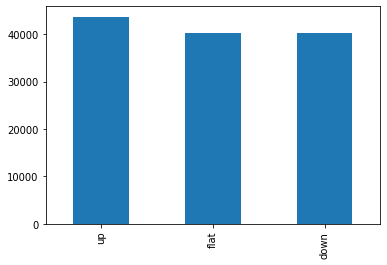

In [ ]:
plot_df = pd.DataFrame(full_targets, columns=["FuturePrice"])
plot_df["FuturePrice"].value_counts().plot(kind = 'bar')

# Mulitclass Classification (None CDT 1D CNN)

In [ ]:
full.columns

Index(['Time', 'Open', 'High', 'Low', 'Close', 'Volume',
       'VolumeWeightedAvgPrice'],
      dtype='object')

In [ ]:
full["Open"]

timestamp
2016-04-25 10:30:00-04:00     68.81
2016-04-25 10:35:00-04:00     68.88
2016-04-25 10:40:00-04:00     68.91
2016-04-25 10:45:00-04:00     68.90
2016-04-25 10:50:00-04:00     68.94
                              ...  
2021-01-19 08:50:00-05:00    145.00
2021-01-19 09:00:00-05:00    144.98
2021-01-19 09:10:00-05:00    144.98
2021-01-19 09:15:00-05:00    144.93
2021-01-19 09:20:00-05:00    144.81
Name: Open, Length: 124174, dtype: float64

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaled_df = pd.DataFrame()

scaler = MinMaxScaler()

scaled_train = scaler.fit_transform(train[['Open', 'High', 'Low', 'Close', 'Volume']])
scaled_val = scaler.fit_transform(val[['Open', 'High', 'Low', 'Close', 'Volume']])
scaled_test = scaler.fit_transform(test[['Open', 'High', 'Low', 'Close', 'Volume']])

In [ ]:
train_targets_df = pd.DataFrame(train_targets)
val_targets_df = pd.DataFrame(val_targets)
test_targets_df = pd.DataFrame(test_targets)

class2idx = {
    "up":0,
    "flat":1,
    "down":2,
}

idx2class = {v: k for k, v in class2idx.items()}

train_targets_df.replace(class2idx, inplace=True)
val_targets_df.replace(class2idx, inplace=True)
test_targets_df.replace(class2idx, inplace=True)

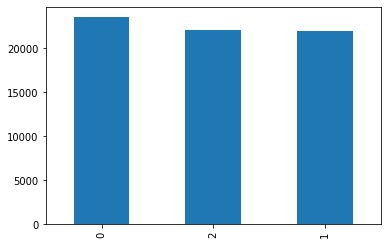

In [ ]:
train_targets_df[0].value_counts().plot(kind = 'bar')

In [ ]:
X_train = np.array(scaled_train)
X_val = np.array(scaled_val)
X_test= np.array(scaled_test)

y_train = np.array(train_targets_df[0])
y_val = np.array(val_targets_df[0])
y_test = np.array(test_targets_df[0])

In [ ]:
print(f'Type of X Train: {type(X_train)}, Length of X: {X_train.shape}')
print(f'Type of y Train: {type(y_train)}, Length of y: {y_train.shape}')
print(f'Type of X Val: {type(X_val)}, Length of X: {X_val.shape}')
print(f'Type of y Val: {type(y_val)}, Length of y: {y_val.shape}')
print(f'Type of X Val: {type(X_test)}, Length of X: {X_test.shape}')
print(f'Type of y Val: {type(y_test)}, Length of y: {y_test.shape}')

Type of X Train: <class 'numpy.ndarray'>, Length of X: (67653, 5)
Type of y Train: <class 'numpy.ndarray'>, Length of y: (67653,)
Type of X Val: <class 'numpy.ndarray'>, Length of X: (25027, 5)
Type of y Val: <class 'numpy.ndarray'>, Length of y: (25027,)
Type of X Val: <class 'numpy.ndarray'>, Length of X: (31494, 5)
Type of y Val: <class 'numpy.ndarray'>, Length of y: (31494,)


In [ ]:
np.asarray(train)

array([[Timestamp('2016-04-25 10:30:00-0400', tz='US/Eastern'), 68.81,
        68.88, ..., 68.88, 52095, 68.824087],
       [Timestamp('2016-04-25 10:35:00-0400', tz='US/Eastern'), 68.88,
        68.92, ..., 68.905, 55508, 68.901144],
       [Timestamp('2016-04-25 10:40:00-0400', tz='US/Eastern'), 68.91,
        68.9301, ..., 68.9, 37356, 68.911471],
       ...,
       [Timestamp('2019-01-18 17:00:00-0500', tz='US/Eastern'), 97.73,
        97.73, ..., 97.73, 100, 97.73],
       [Timestamp('2019-01-18 17:25:00-0500', tz='US/Eastern'), 97.7299,
        97.73, ..., 97.73, 627, 97.729968],
       [Timestamp('2019-01-18 19:55:00-0500', tz='US/Eastern'), 97.73,
        97.73, ..., 97.73, 100, 97.73]], dtype=object)

In [ ]:
class ClassifierDataset():
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [ ]:
scaled_train.shape[1]

5

In [ ]:
EPOCHS = 300
BATCH_SIZE = 16
LEARNING_RATE = 0.0007
NUM_FEATURES = scaled_train.shape[1]
NUM_CLASSES = 3

In [ ]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [ ]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=5, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [ ]:
print("Begin training.")

for e in tqdm(range(1, EPOCHS+1)):
  
  # TRAINING
  train_epoch_loss = 0
  train_epoch_acc = 0


  model.train()
  for X_train_batch, y_train_batch in train_loader:
      X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
      optimizer.zero_grad()
      
      y_train_pred = model(X_train_batch)
      
      train_loss = criterion(y_train_pred, y_train_batch)
      train_acc = multi_acc(y_train_pred, y_train_batch)
      
      train_loss.backward()
      optimizer.step()
      
      train_epoch_loss += train_loss.item()
      train_epoch_acc += train_acc.item()
      
      
  # VALIDATION    
  with torch.no_grad():
      
      val_epoch_loss = 0
      val_epoch_acc = 0
      
      model.eval()
      for X_val_batch, y_val_batch in val_loader:
          X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
          
          y_val_pred = model(X_val_batch)
                      
          val_loss = criterion(y_val_pred, y_val_batch)
          val_acc = multi_acc(y_val_pred, y_val_batch)
          
          val_epoch_loss += val_loss.item()
          val_epoch_acc += val_acc.item()

  loss_stats['train'].append(train_epoch_loss/len(train_loader))
  loss_stats['val'].append(val_epoch_loss/len(val_loader))
  accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
  accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                            

  print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.03773 | Val Loss: 18.28548 | Train Acc: 46.339| Val Acc: 35.978
Epoch 002: | Train Loss: 1.03568 | Val Loss: 14.71919 | Train Acc: 46.572| Val Acc: 35.846
Epoch 003: | Train Loss: 1.03342 | Val Loss: 16.51808 | Train Acc: 46.793| Val Acc: 36.061
Epoch 004: | Train Loss: 1.03213 | Val Loss: 21.83980 | Train Acc: 46.823| Val Acc: 36.041
Epoch 005: | Train Loss: 1.03002 | Val Loss: 22.58325 | Train Acc: 47.167| Val Acc: 35.862
Epoch 006: | Train Loss: 1.02964 | Val Loss: 22.80922 | Train Acc: 47.228| Val Acc: 35.958
Epoch 007: | Train Loss: 1.02630 | Val Loss: 22.72420 | Train Acc: 47.528| Val Acc: 35.934
Epoch 008: | Train Loss: 1.02479 | Val Loss: 22.38807 | Train Acc: 47.576| Val Acc: 35.902
Epoch 009: | Train Loss: 1.02515 | Val Loss: 22.53223 | Train Acc: 47.479| Val Acc: 36.077
Epoch 010: | Train Loss: 1.02227 | Val Loss: 23.79687 | Train Acc: 47.802| Val Acc: 35.974
Epoch 011: | Train Loss: 1.02061 | Val Loss: 24.85404 | Train Acc: 47.934| Val Acc: 35.866

KeyboardInterrupt: ignored

# APPENDIX

In [ ]:
plot_df = pd.DataFrame(full_targets, columns=["FuturePrice"])

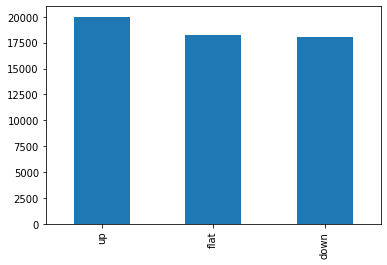

In [ ]:
plot_df["FuturePrice"].value_counts().plot(kind = 'bar')

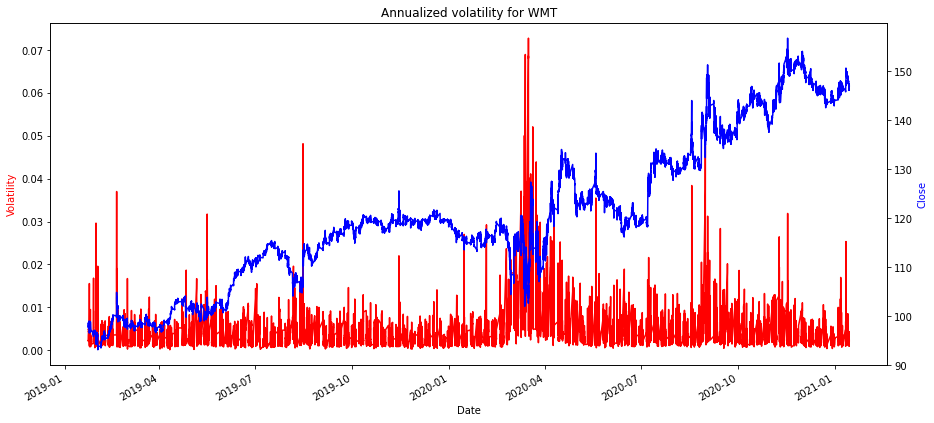

In [ ]:
def buildTargets_VolOnly(full_df = full, train_observations = train.shape[0], 
                         val_observations = val.shape[0], 
                         test_observations = test.shape[0], 
                         alph = 0.55, volity_int = 10):

  """ 
  This function will take a complete set of train, val, and test data and return the targets.
  Volitility will be calculated over the 252 5min incriments 
  The Target shift is looking at 2 hours shift from current time
  """

  returns = np.log(full_df['Close']/(full_df['Close'].shift(1)))
  returns.fillna(0, inplace=True)
  #volatility = returns.std()*np.sqrt(volity_int)
  volatility = returns.rolling(window=volity_int).std()*np.sqrt(volity_int)



  return volatility
  #return train_targets, val_targets, test_targets, full_targets

volatility = buildTargets_VolOnly()

fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(1, 1, 1)
volatility.plot(ax=ax1, color = "red")
ax1.set_xlabel('Date')
ax1.set_ylabel('Volatility', color = "red")
ax1.set_title(f'Annualized volatility for {ticker}')
ax2 = ax1.twinx()
full.Close.plot(ax=ax2, color = "blue")
ax2.set_ylabel('Close', color = "blue")
plt.show()

In [ ]:
X,y=data.data,data.target
# Since the default in the file is 0=malignant 1=benign we want to reverse these
y=(y==0).astype(int)
X,y= np.array(X),np.array(y)

# Let's set aside a test set and use the remainder for training and cross-validation
X_train,X_test,y_train,y_test = train_test_split(X, y, random_state=0,test_size=0.2)

# Let's scale our data to help the algorithm converge faster
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
full.drop(columns=['Time', ])

In [ ]:
from sklearn.datasets import load_breast_cancer

In [ ]:
data=load_breast_cancer(as_frame=True)

In [ ]:
data.target

0      0
1      0
2      0
3      0
4      0
      ..
564    0
565    0
566    0
567    0
568    1
Name: target, Length: 569, dtype: int64